In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
# import importlib
# import seaborn as sns

user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

### Load Data

In [2]:
file_list = user_path + '/PHYS469/saturation_spectroscopy/interim_data_list.txt'
oct10_raw_data = {}

with open(file_list, 'r') as file_names:
    # Go through good data files
    for file_path in file_names:
        file_path = file_path.strip()
        # Read the lines of the file
        with open(user_path+file_path, 'r') as f:
            lines = f.readlines()
        # Find end of the header (the line that starts with 'x ys')
        for i, line in enumerate(lines):
            if line.startswith('x	y'):
                lines_to_skip = i
                break

        # Read data (skip header)
        data = np.genfromtxt(user_path+file_path, skip_header=lines_to_skip, names=True, missing_values='nan', filling_values=0)
        reshaped_data = np.vstack([data[field] for field in data.dtype.names]).T

        # Add to a dict
        file_dict = {label: reshaped_data[:,i] for i,label in enumerate(data.dtype.names)}
        oct10_raw_data[file_path[53:57]] = file_dict

### Plot Data

In [69]:
data_time = oct10_raw_data['run3']['x']
data_voltage = -oct10_raw_data['run3']['y3']

In [70]:
def gaussian(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / (2 * c**2)) + d

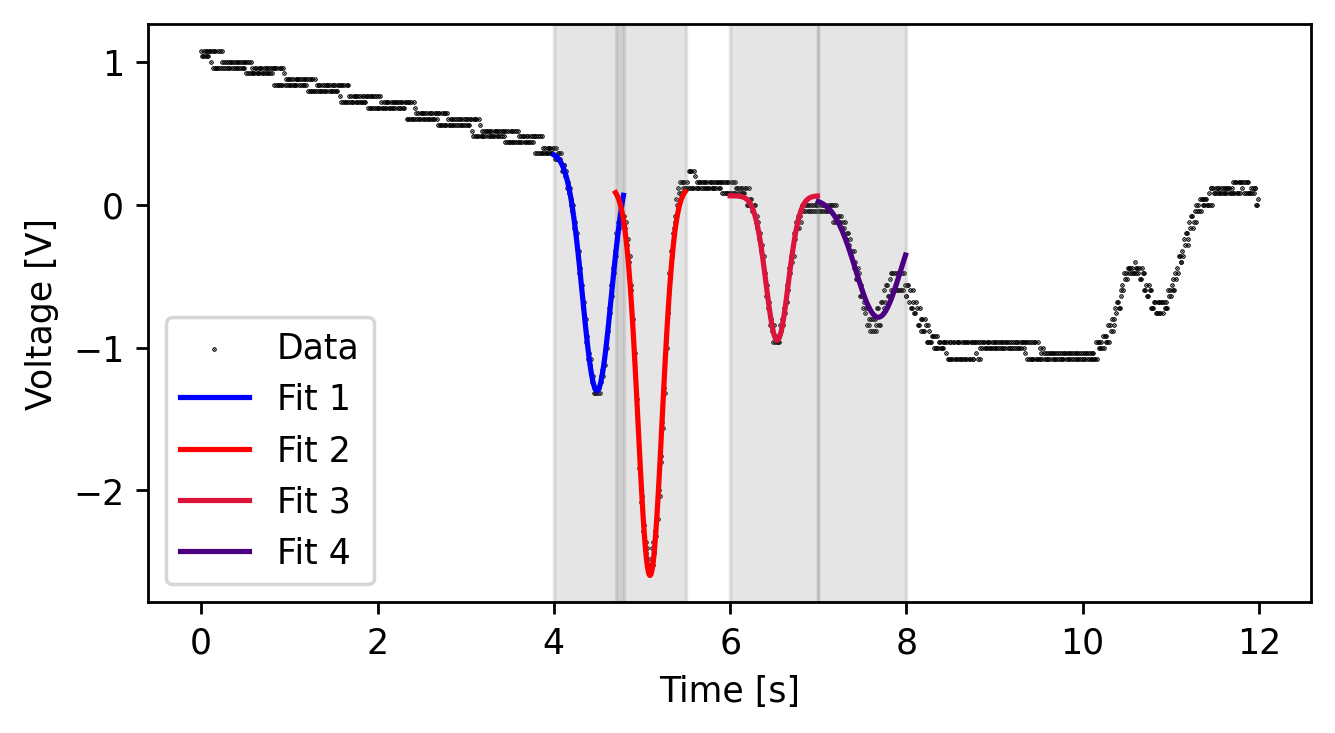

In [140]:
time_multiplier = 1000
colors = ['blue', 'red', 'crimson', 'indigo']

# Get data slices for each dip
slice_edges = np.array([0.004, 0.0048, 0.0047, 0.0055, 0.006, 0.007, 0.007, 0.008])
slice_indices = [np.argmin(np.abs(edge - data_time)) for edge in slice_edges]

# Figure
plt.figure(figsize=(6,3), dpi=250)

# Plot data
plt.scatter(data_time*time_multiplier, data_voltage, color='k', s=0.1, label = 'Data')

# to vizualize the slices (we dont have to keep this, it was mostly for myself hehe)
for start,stop in zip(slice_edges[:-1:2], slice_edges[1::2]):
    plt.axvspan(start*time_multiplier, stop*time_multiplier, color='gray', alpha=0.2)

# Fit the data
fit_dict = {}
for i,(start,stop) in enumerate(zip(slice_indices[:-1:2], slice_indices[1::2])):
    popt, pcov = opt.curve_fit(gaussian, data_time[start:stop], data_voltage[start:stop], 
                               p0=[-1, data_time[int((stop - start) / 2) + start], 0.0002, -1])
    # Add to dictionary
    fit_dict[f'popt_{i}'] = popt
    fit_dict[f'err_{i}'] = np.sqrt(np.diag(pcov))
    # Plot the fit
    fit_voltage = gaussian(data_time[start:stop], *popt)
    plt.plot(data_time[start:stop]*time_multiplier, fit_voltage, label = f'Fit {i+1}', color=colors[i])
    # put params in plot legend instead?

# Labels
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()

plt.savefig(user_path + '/PHYS469/saturation_spectroscopy/figures/voltage-time.png')
plt.show()

In [110]:
fit_dict

{'popt_0': array([-1.66914087e+00,  4.48863580e-03,  1.62961345e-04,  3.68100361e-01]),
 'err_0': array([1.96426486e-02, 1.42294249e-06, 2.59200832e-06, 1.86890409e-02]),
 'popt_1': array([-2.72489484e+00,  5.09088259e-03, -1.36104550e-04,  1.28923862e-01]),
 'err_1': array([4.10361968e-02, 1.75343029e-06, 3.01822358e-06, 3.69583542e-02]),
 'popt_2': array([-1.01166944e+00,  6.53388732e-03,  1.26516589e-04,  6.31387287e-02]),
 'err_2': array([1.53857938e-02, 2.00427937e-06, 2.59412790e-06, 9.35169954e-03]),
 'popt_3': array([-8.33332263e-01,  7.68060381e-03,  2.54490776e-04,  4.60755399e-02]),
 'err_3': array([3.20793752e-02, 6.75757720e-06, 1.35835246e-05, 3.29343769e-02])}

/var/folders/2g/h368by4j4039rpj44l4rngpc0000gn/T/ipykernel_4287/2183025166.py:5: RuntimeWarning: divide by zero encountered in true_divide
  residuals = (data_voltage[start:stop] - fit_voltage) / data_voltage[start:stop] * 100


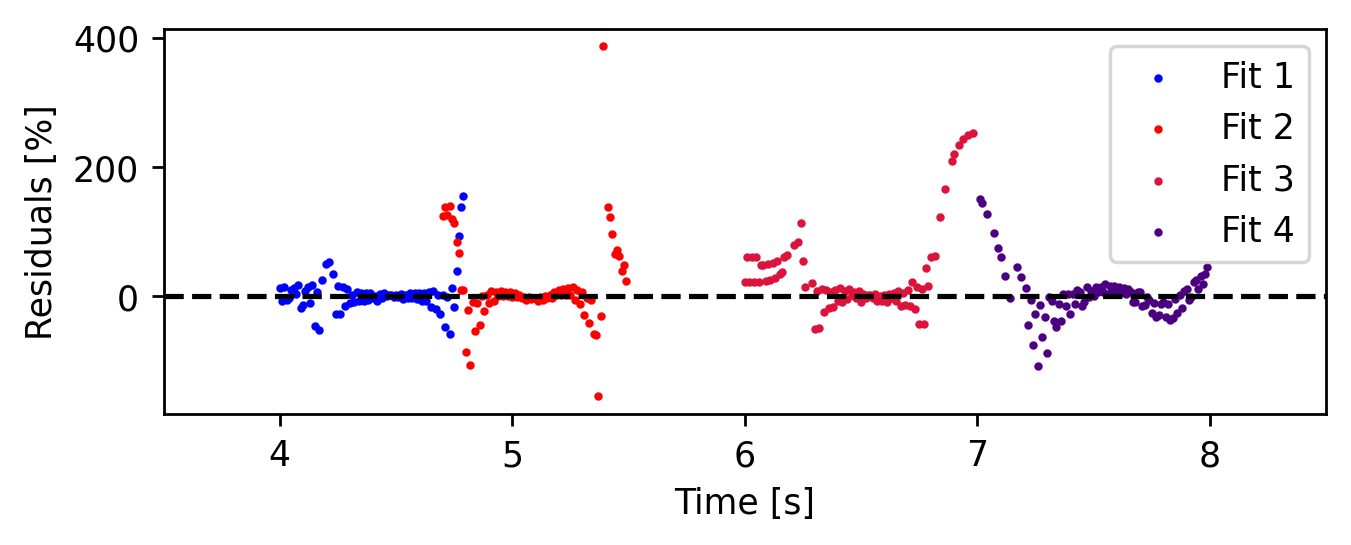

In [141]:
# plot residuals for the fits
plt.figure(figsize=(6,2), dpi=250)
for i,(start,stop) in enumerate(zip(slice_indices[:-1:2], slice_indices[1::2])):
    fit_voltage = gaussian(data_time[start:stop], *fit_dict[f'popt_{i}'])
    residuals = (data_voltage[start:stop] - fit_voltage) / data_voltage[start:stop] * 100
    plt.scatter(data_time[start:stop]*time_multiplier, residuals, label = f'Fit {i+1}', s = 2, color=colors[i])

plt.hlines(0, data_time[slice_indices[0]]*time_multiplier - 0.5, data_time[slice_indices[-1]]*time_multiplier + 0.5, color='k', linestyle='--')
plt.xlim(data_time[slice_indices[0]]*time_multiplier - 0.5, data_time[slice_indices[-1]]*time_multiplier + 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Residuals [%]')
plt.legend(loc = 'upper right')
plt.savefig(user_path + '/PHYS469/saturation_spectroscopy/figures/residuals.png')

In [73]:
# all the fit value are saved in fit_dict, in order from left to right (see plot)
# names are popt_0, err_0, popt_1, err_1, etc.

In [113]:
# getting FWHM of all fits
fwhm = [2*np.sqrt(2*np.log(2))*fit_dict[f'popt_{i}'][2] for i in range(int(len(fit_dict)/2))]
fwhm_err = [2*np.sqrt(2*np.log(2))*fit_dict[f'err_{i}'][2] for i in range(int(len(fit_dict)/2))]
print(fwhm)


[0.0003837446410558674, -0.0003205017215059242, 0.000297923800712964, 0.000599279981695292]


In [139]:
# chi square of fits
chi_square = [np.sum((data_voltage[start:stop] - gaussian(data_time[start:stop], *fit_dict[f'popt_{i}']))**2 / gaussian(data_time[start:stop], *fit_dict[f'popt_{i}'])) for i,(start,stop) in enumerate(zip(slice_indices[:-1:2], slice_indices[1::2]))]
print(chi_square)

[-0.8429848730683173, 8.910869694569904, 2.458966579505602, -3.2813353189030545]


### Calculations

In [112]:
# Constants
k_B = 1.380649e-23  # Boltzmann constant in J/K
T_Celsius = 45.6  # Temperature in Celsius
T_Kelvin = T_Celsius + 273.15  # Convert to Kelvin
mass_85Rb = 1.409993199e-25  # Mass of 85Rb in kg
mass_87Rb = 1.44316060e-25   # Mass of 87Rb in kg

# Convert Celsius to Kelvin
T = T_Kelvin

# Doppler broadening FWHM formula for velocity
def doppler_fwhm(T, mass):
    return np.sqrt(8 * k_B * T * np.log(2) / mass)

# Calculate FWHM for each isotope, and multiply by the central frequency of the laser
fwhm_85Rb = doppler_fwhm(T, mass_85Rb) * 780e-9 
fwhm_87Rb = doppler_fwhm(T, mass_87Rb) * 780e-9 

print(f'FWHM for 85Rb: {fwhm_85Rb} s')
print(f'FWHM for 87Rb: {fwhm_87Rb} s')

FWHM for 85Rb: 0.00032449690269018765 s
FWHM for 87Rb: 0.0003207463574125443 s


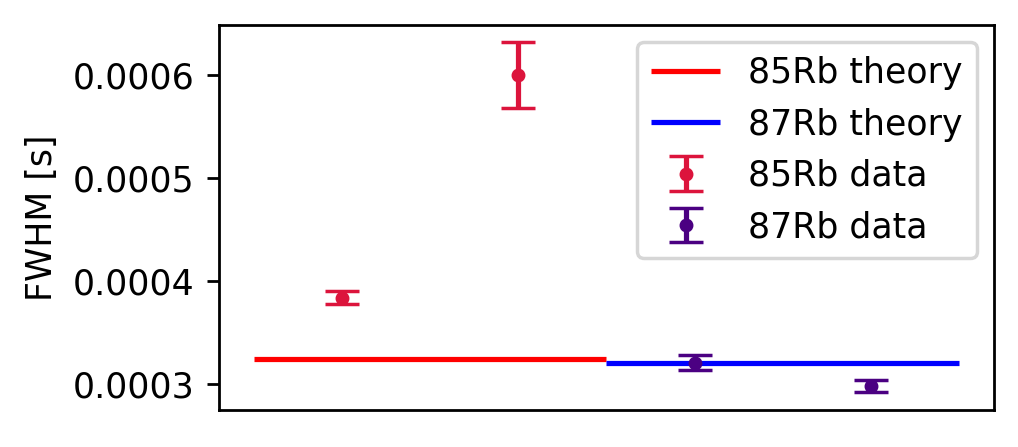

In [142]:
# plot the FWHM
plt.figure(figsize=(4, 2), dpi=250)
# plt.scatter(np.arange(len(fwhm)), np.abs(fwhm), label = 'Data')

plt.errorbar([0.25, 0.75], [fwhm[0], fwhm[3]], yerr = [fwhm_err[0], fwhm_err[3]],  color = 'crimson', label = '85Rb data', fmt = '.', capsize=5)
plt.errorbar([1.25, 1.75], [np.abs(fwhm[1]), fwhm[2]], yerr = [fwhm_err[1], fwhm_err[2]], color = 'indigo', label = '87Rb data', fmt = '.', capsize = 5)

plt.hlines(fwhm_85Rb, 0, 1, color='r', label = '85Rb theory')
plt.hlines(fwhm_87Rb, 1, 2, color='b', label = '87Rb theory')
plt.xticks([])
plt.ylabel('FWHM [s]')
plt.legend(loc = 'upper right')
plt.savefig(user_path + '/PHYS469/saturation_spectroscopy/figures/fwhm_fits.png')